<a href="https://colab.research.google.com/github/angelmorenocalvo/taller_TensorFlow/blob/master/Cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificion de imágenes de ropa

En este tutorial, entrenaremos una red neuronal para clasificar imagenes de ropa como botas, calcetines o camisetas.

## Dependencias
Necesitaremso la api de las bases de datos de TensorFLow, def esta forma nos resultara más sencillo el acceso a la base de datos.

In [1]:
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (1.3.0)


In [2]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
import tensorflow_datasets as tfds

import math
import numpy as np
import matplotlib.pyplot as plt

## Importar Fashion MNIST dataset

 Usaremos la base de datos Fashion MNIST, que contiene 70000 imagenes es escala de grises en 10 categorias. Las imágienes muestran articulos de ropa en una resolución de (28*28pixels), y se ven de la siguiente manera:

 <table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite" width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>
 

 Esta base de datos es usada muy a menudo como el hola mundo del machine learning para el computer vision. 

 Usaremos 60,000 imagenes pare el entrenamiento de la red neuronal, mientras que las 10,000 restantes serviran para evaluar la precisión de la clasificación por parte de la red.

 

In [4]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/1.0.0. Subsequent calls will reuse this data.


Cuando cargamos la base de datos nos retorna metadata al igual qeu la bases de datos de entrenamiento y test.
- El modelo se entrenara usando `train_dataset`.
- El modelo se testea con `test_dataset`.

Las imagenes seran arrays de 28*28, con pixeles que tienen rangos comprendidos de [0,28]. Las etiquetas seran arrays de enteros en un rango de [0,9].
Los cuales corresponden con:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>Camiseta/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Pantalón</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Jersey</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Vestido</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Abrigo</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandalia</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Camisa</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Deportiva</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Mochila</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle Bota</td>
  </tr>
</table>

Cada imagen se asigna a una sola etiqueta. Dado que los nombres de clase no se incluyen con el conjunto de datos, los guardaremos en un array para usarlos más adelante al trazar las imágenes:


In [0]:
class_names = ['Camiseta/top', 'Pantalon', 'Jersey', 'Vestido', 'Abrigo', 'Sandalias', 'Camisa', 'Deportiva', 'Mochila', 'Bota']

## Exploremos los datos
Antes de entrenar camos a ver como son los datos del modelo. Con este código veremos qeu hay 60,000 imagenes en el set de entrenameitno y 10,000 en el set de de prueba:

In [6]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Número de ejemplos de entrenamiento:{}".format(num_train_examples))
print("Número de ejemplos de test:{}".format(num_test_examples))

Número de ejemplos de entrenamiento:60000
Número de ejemplos de test:10000


## Preprocesamiento de datos

El valor de cada pixel de los datos de la imagen es un entero en el rango [0,255]. Para que el modelo trabaje de forma apropiada, los valores tienen que ser normalizados en el rango [0,1]. Por lo que crearemos una función de normalización y la aplicaremos para cada imagen en ambos datasets.

In [0]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# La funcion map aplica la normalizacion de la funcion a cada elemento 
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

# La primera vez que se use el dataset, la imagen sera descargada desde el disco
# El almacenamiento en caché los mantendrá en la memoria, haciendo que el 
# entrenamiento sea más rápido
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

## Explorando los datos procesados

vamos a mostrar la imagen.

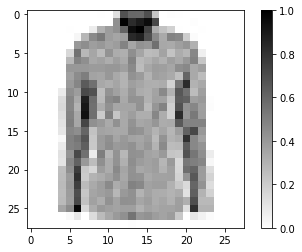

In [8]:
# Cogemos una sola imagen, y borramos la dimension del color con reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

# mostrar la imagen
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()


Sacar por pantalla las primers 25 imagenes de los datasets con el nombre debajo de la imagen. Comprueba que los datos tienen el formato correcto y estan preparados para entrenar la red.

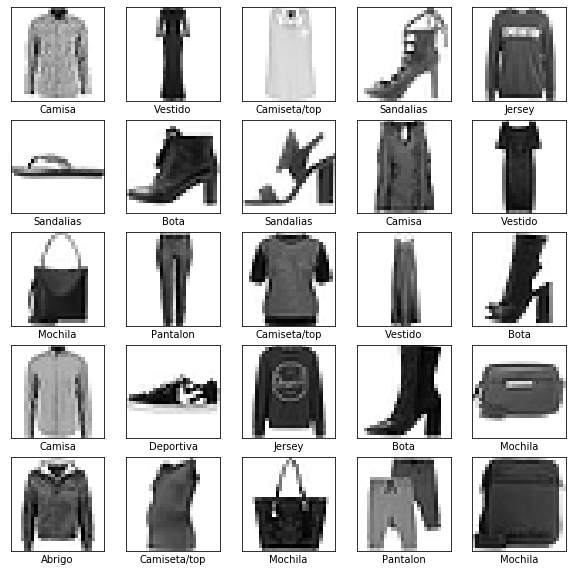

In [8]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
  image = image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(class_names[label])
  i+=1
plt.show()

# Desarrollando el modelo
El desarrollo de la red neuronal requiere configurar las capas del modelo y despues compilar el modelo.

### Configurar el modelo
- **convolutions** `tf.keras.layers.Conv2D`y `MaxPooling2D` $\rightarrow$ La red empieza con dos parejas de Conv/MaxPool. La primera capa es un filtro Conv2D(3,3) que se aplica a la imagen de entrada,  conservando el tamaño original de la imagen usando relleno, y creando 32 output(convoluted) imagenes( por lo que esta capa crea 32 convoluted imagenes del mismo tamaño que la entrada). Despues, las 32 output son reducidas de tamaño a traves de MaxPooling2D(2,2) con un stride(paso) de 2. El siguente Conv2D tambien tiene un kernel (3,3), coge als 32 imagenes como entradas y crea 64 outputs las cuales son otra vez reducidas en tamaño con una capa MaxPooling2D  . 
- **output** `tf.keras.layers.Dense` $\rightarrow$ serán 128 neuronas seguidas por 10 nodos de la capa softmax. Cada uno de los nodos representan las clases de ropa . COmo en la anterior capa la capa final toma como input los 128 nodos de la capa anterior y como salidas la probabilidad de las imagenes en rango [0,1] representando la probabilidad de cada clase.

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])

### Compilar el modelo
Antes de qeu el modelo esté listo para ser entrenado, necesita algunas configuraciones más:
- **Loss funtion** $\rightarrow$ Algoritmo para meidr como de rapido las salidas están de la salida deseada. El objetivo del entrenamiento es reducir la perdida(loss).
- **Optimizer** $\rightarrow$ Algoritmo para ajustar los parametros internos del modelo para minimizar 'loss'
- **Metrics** $\rightarrow$ Usado para monitorizar el entrenamiento y los pasos de testeo. En este caso usaremos accuracy, la fraccion de las imagenes qeu son correctamente clasificadas.

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Entrenando el modelo

Primero, definiremos el comportamiento de iteracción para el entrenamiento del dataset:
1. Repetir para siempre especificando(repeat forever by specifying) `dataset.repeat()` (el parametro `epoch` describe cuantas veces se repetirá el entrenamiento
2. El `dataset.shuffle(60000)` randomiza el orden en el que los inputs son recibido por la red, de esta forma no puede aprender nada por el orden recepcción.
3. El `epochs=5` limita el entrenamiento a 5 iteraciones enteras en el dataset, por lo que son $5*60000=300000$ examples.

(El requerimiento de `steps_per_epoch`, es una bandera que en el futuro sera eliminada.)

In [0]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [13]:
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Train for 1875 steps
Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1286 - accuracy: 0.9523
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1091 - accuracy: 0.9598
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0909 - accuracy: 0.9666
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0760 - accuracy: 0.9711
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0635 - accuracy: 0.9770
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0554 - accuracy: 0.9796
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0454 - accuracy: 0.9832
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0391 - accuracy: 0.9856
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0357 - accuracy: 0.9868
Epoch 10/10
1875/1875 [==============================] - 6s 3

A la vez que el modelo entrena, la funcion de loss y las accuracy metrics son impresas. Este modelo alcanza un accuracy de al rededor del 0.97, lo que es igual a que acierta el 98% de las veces.

## Evaluando la exactitud

Vamos a comprobar como el modelo como realiza en el dataset test. Usaremos todos los ejemplos nosotros tenemos en el test dataset para evaluar la exactitud.

In [14]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 2s 8ms/step - loss: 0.4493 - accuracy: 0.9177
Accuracy on test dataset: 0.9177


Como resulta, el accuracy del test es mas pequeño que en el caso del de entrenamiento. Esto es completamente normal. Cuando el modelo utiliza datos que nunca a visto(test), podemos esperar que el rendimiento baje.

## Hacer predicciones y explorar

COn el modelo entrenado nosostros podemos usarlo para predecir sobre algunas imagenes.

In [0]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [15]:
predictions.shape

(32, 10)

El modelo ha predecido el label de la imagen qeu hemos testeado, vamos a ver la predicción:

In [16]:
predictions[0]

array([9.1337097e-06, 6.9841491e-08, 5.2756271e-03, 1.2542040e-04,
       6.6055588e-02, 3.8576701e-07, 9.2853040e-01, 3.6099446e-09,
       3.3110086e-06, 9.4111456e-09], dtype=float32)

La predicción es un array de 10 elementos, que correspondes a la confianza que otorga el modelo a la posibilidad de que sea esa la label correcta

In [17]:
np.argmax(predictions[0])

6

El modelo dice qeu este elemento es una camisa, o la cass_names[6]. Y podemos comprobarlo:

In [18]:
test_labels[0]

6

Podemos graficarlo

In [0]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Vamos a ver la imagen 0, predicciones y array prediction

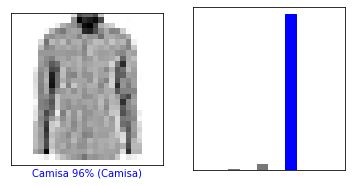

In [20]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

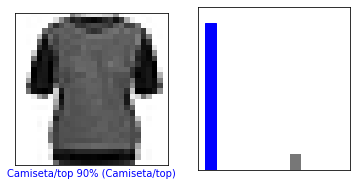

In [20]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

Vamos a mostrar varias imagenes con sus predicciones. Las predicciones en azul son correctas, mientras que las predicciones en rojo son incorrectas. EL número dado es el  porcentaje de la predicción de la label. Date cuenta que puede dar un error alto hasta con una buena confianza.

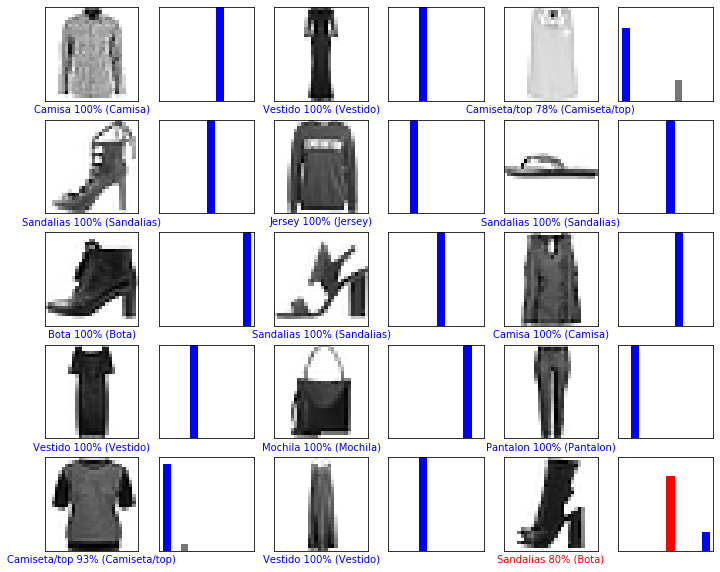

In [19]:
# Plot Los primeras X test imagenes, el label predecido, y el valor real
# El color correcto esta en azul, el incorrecto en rojo
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

Para acabar, usa el modelo entrenado para hacer predicciones de una sola imagen 

In [24]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


El modelo `tf.keras` esta optimizado para hacer predicciones en el batch, o colecciones, de ejemplos a la vez. Por lo qeu aunque usemos una sola imagen tenemos que darle una lista: 

In [25]:
# Añade la imagen al batch donde esta el unico elemento
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


Ahora pridece la imagen:

In [27]:
predictions_single = model.predict(img)

print(predictions_single)

[[9.1336933e-06 6.9841505e-08 5.2756229e-03 1.2542032e-04 6.6055506e-02
  3.8576599e-07 9.2853057e-01 3.6099381e-09 3.3110093e-06 9.4111474e-09]]


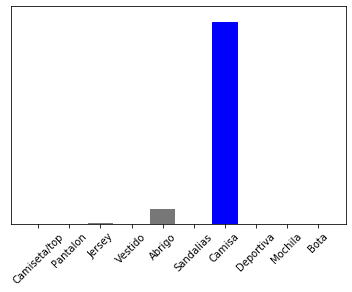

In [28]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

`model.predict` retorna una lista de listas, una de estas imagenes en el batch del data. Graba las predicciones de nuestra unica imagen en el batch:

In [29]:
np.argmax(predictions_single[0])

6

Y despues el modelo predice el label de 6(una camiseta).